In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import Libaries

In [ ]:
# Data Operations
import numpy as np  # Importing NumPy for numerical operations
import pandas as pd  # Importing Pandas for data manipulation and analysis
import os  # Importing os module for interacting with the operating system

# Visualization/Image Processing
import cv2  # Importing OpenCV for image processing
import matplotlib.pyplot as plt  # Importing matplotlib for plotting and visualization

# Machine Learning
import tensorflow as tf  # Importing TensorFlow for machine learning and deep learning
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense  # Importing specific layers for building neural networks

from sklearn.model_selection import train_test_split  # Importing function for splitting data into train and test sets

# Miscellaneous
import glob  # Importing glob for filename pattern matching
import os  # Redundant import, os is already imported above



#Data Observations

    There ara multiple cars in some images with multiple boundary boxes in them
    We must build a model regarding these boxes all for one image. Otherwise accuracy will get much lower


In [ ]:
# Fetching the file paths for training and testing images
train_images_paths = glob.glob("/content/drive/MyDrive/imprtant new /data/training_images/*")  # Using glob to get a list of all image file paths in the training_images directory
test_images_paths = glob.glob("/content/drive/MyDrive/imprtant new /data/testing_images/*")  # Using glob to get a list of all image file paths in the testing_images directory

# Printing out the size of the training and testing datasets
print(f"Train images data size is {len(train_images_paths)} besides test images data size is {len(test_images_paths)}")


Train images data size is 1002 besides test images data size is 175


# Preprocessing and Data Loading




In [ ]:
# Loading bounding box annotations for training data
train = pd.read_csv("/content/drive/MyDrive/imprtant new /data/train_solution_bounding_boxes (1).csv")
# Grouping bounding box coordinates by image and converting them to a list of integers
train = train.groupby("image")[["xmin", "ymin", "xmax", "ymax"]].apply(lambda x: x.values.astype(int).flatten().tolist()).reset_index()
# Renaming the column containing the bounding box coordinates for clarity
train.rename(columns={0: "coordinates"}, inplace=True)
# Finding the maximum length of bounding box coordinate list across all images
max_length = train["coordinates"].apply(len).max()
# Padding shorter bounding box coordinate lists with zeros to ensure consistent length
train["coordinates"] = train["coordinates"].aggregate(lambda x: x + [0] * (max_length - len(x)))


In [ ]:
train


image                                        coordinates
0     vid_4_1000.jpg  [281, 187, 327, 223, 0, 0, 0, 0, 0, 0, 0, 0, 0...
1    vid_4_10000.jpg  [15, 187, 120, 236, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2    vid_4_10020.jpg  [496, 172, 630, 231, 0, 0, 0, 0, 0, 0, 0, 0, 0...
3    vid_4_10040.jpg  [239, 176, 361, 236, 0, 0, 0, 0, 0, 0, 0, 0, 0...
4    vid_4_10060.jpg  [16, 186, 132, 238, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
..               ...                                                ...
350   vid_4_9860.jpg  [0, 198, 49, 236, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
351   vid_4_9880.jpg  [329, 156, 536, 250, 0, 0, 0, 0, 0, 0, 0, 0, 0...
352   vid_4_9900.jpg  [0, 168, 141, 239, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
353   vid_4_9960.jpg  [487, 172, 616, 228, 0, 0, 0, 0, 0, 0, 0, 0, 0...
354   vid_4_9980.jpg  [221, 182, 348, 238, 0, 0, 0, 0, 0, 0, 0, 0, 0...

[355 rows x 2 columns]

In [ ]:
len(train)

355

In [ ]:
train["coordinates"].apply(len).min()

28

In [ ]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        355 non-null    object
 1   coordinates  355 non-null    object
dtypes: object(2)
memory usage: 5.7+ KB


# Preprocessing

# Displaying Some Images


In [ ]:
# Defining a function to display images with optional bounding boxes
def display_image(img, bbox_coords=[], pred_coords=[], normalize=False):
    """
    Displays an image with optional bounding boxes for ground truth and predictions.

    Parameters:
        img (ndarray): The image to be displayed.
        bbox_coords (list, optional): A list of ground truth bounding box coordinates.
            Each bounding box is represented by [xmin, ymin, xmax, ymax]. Defaults to an empty list.
        pred_coords (list, optional): A list of predicted bounding box coordinates.
            Each bounding box is represented by [xmin, ymin, xmax, ymax]. Defaults to an empty list.
        normalize (bool, optional): If True, the image will be normalized (i.e., rescaled to [0, 1]).
            This is important for displaying images read with OpenCV or other libraries that do not
            automatically normalize the pixel values. Defaults to False.

    The function draws the ground truth bounding boxes in green and the predicted bounding boxes in red.
    The image is displayed without axes.
    """
    if normalize:
        img = img / 255.0  # Normalize the image pixel values to [0, 1]

    while len(pred_coords) > 0:
        xmin, ymin, xmax, ymax = pred_coords[:4]
        pred_coords = pred_coords[4:]
        cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), thickness=2)  # Draw predicted bounding box in red

    while len(bbox_coords) > 0:
        xmin, ymin, xmax, ymax = bbox_coords[:4]
        bbox_coords = bbox_coords[4:]
        cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), thickness=2)  # Draw ground truth bounding box in green

    plt.imshow(img)
    plt.axis("off")  # Hide axes
    plt.show()  # Show the image


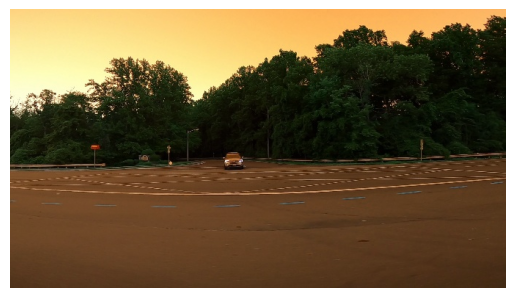

In [ ]:
# Adding the full image paths to the DataFrame
train["image_path"] = "/content/drive/MyDrive/imprtant new /data/training_images/" + train["image"]

# Reading and displaying the first image in the training dataset
display_image(cv2.imread(train["image_path"][0]))


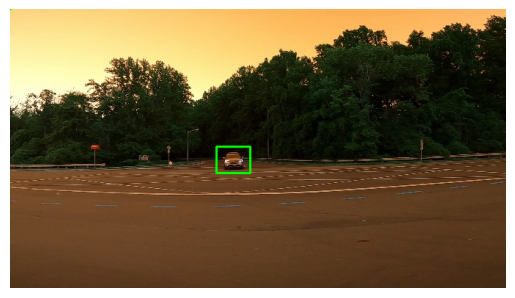

In [ ]:
# Reading the first image in the training dataset
img = cv2.imread(train["image_path"][0])

# Retrieving the ground truth bounding box coordinates for the first image
bbox_coords = train["coordinates"][0]

# Displaying the image with the ground truth bounding boxes
display_image(img, bbox_coords=bbox_coords)


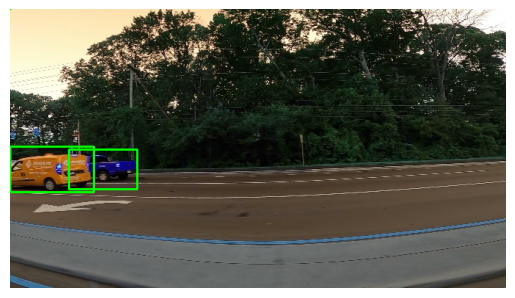

In [ ]:
# The one  within multiple cars and boxes
display_image(cv2.imread(train["image_path"][48]),bbox_coords=train["coordinates"][48])

## Data Generator for Batch Image and Bounding Box Loading


In [ ]:
# Defining a data generator for batch loading images and their bounding box coordinates
def data_generator(df=train, batch_size=16):
    """
    Generator function for yielding batches of images and their bounding box coordinates.

    Args:
    df (pd.DataFrame): DataFrame containing the image paths and bounding box coordinates.
        Default is set to the 'train' DataFrame.
    batch_size (int): Number of images to yield in each batch. Defaults to 16.

    Yields:
    dict: A dictionary containing a batch of images and their corresponding bounding box coordinates.
        The 'image' key maps to a numpy array of shape (batch_size, 380, 676, 3), and the 'coordinates'
        key maps to a numpy array of shape (batch_size, max_length).
    """
    while True:  # Infinite loop to keep generating batches
        # Initializing arrays to store batch of images and bounding box coordinates
        images = np.zeros((batch_size, 380, 676, 3))  # Assuming all images are of size (380, 676, 3)
        bbox_coords = np.zeros((batch_size, max_length))

        # Loop to load images and bounding box coordinates
        for i in range(batch_size):
            # Randomly selecting an index from the DataFrame
            rand_index = np.random.randint(0, df.shape[0])
            # Fetching the image path and bounding box coordinates
            row = df.loc[rand_index, :]
            # Loading and normalizing the image
            img = cv2.imread(row.image_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images[i] = img / 255.0
            bbox_coords[i] = np.array(row.coordinates)

        # Yielding a batch of images and bounding box coordinates
        yield {'image': images}, {'coordinates': bbox_coords}


 # Testing the Data Generator and Displaying Generated Image with Bounding Boxes

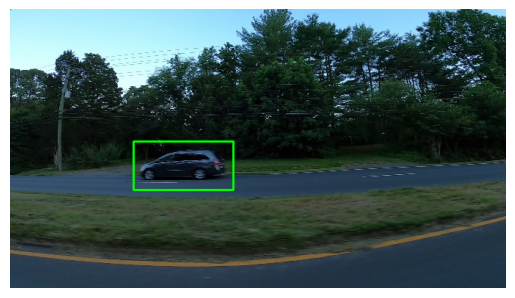

In [ ]:
# Generating a single batch of data using the data generator
img, label = next(data_generator(batch_size=1))

# Extracting the image and bounding box coordinates from the generated batch
img = img["image"][0]
bbox_coords = label['coordinates'][0]

# Displaying the image with the associated bounding box coordinates
display_image(img, bbox_coords=bbox_coords)


#  Building a Convolutional Neural Network (CNN) for Bounding Box Prediction

In [ ]:
# Importing required modules from TensorFlow
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense

# Defining the input shape based on the image dimensions and number of channels
shape = (380, 676, 3)

# Defining the input layer of the neural network
inputs = Input(shape=shape, name="image")

# Initializing the sequential layers of the CNN
x = inputs
n_filters = 0

# Constructing Convolutional Blocks
for i in range(5):  # 5 convolutional blocks
    n_filters = 2 ** (i + 2)  # Incrementing the number of filters in powers of 2
    x = Conv2D(n_filters, 3, activation="relu", padding='same')(x)  # 3x3 Convolutional Layer
    x = BatchNormalization()(x)  # Batch Normalization
    x = MaxPool2D(2, padding='same')(x)  # 2x2 Max Pooling

# Flattening the output of the convolutional blocks
x = Flatten()(x)

# Adding Fully Connected Layers
x = Dense(512, activation="relu")(x)  # First FC layer with 512 neurons
x = Dense(128, activation="relu")(x)  # Second FC layer with 128 neurons

# Output Layer for Bounding Box Prediction
output = Dense(28, activation='relu', name='coordinates')(x)

# Constructing the Model
model = Model(inputs, output)

# Displaying the Summary of the Model
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 380, 676, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 380, 676, 4)       112       
                                                                 
 batch_normalization (Batch  (None, 380, 676, 4)       16        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 190, 338, 4)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 190, 338, 8)       296       
                                                                 
 batch_normalization_1 (Bat  (None, 190, 338, 8)       32    

# Compiling the Convolutional Neural Network Model

In [ ]:
# Importing the Adam optimizer from TensorFlow
from tensorflow.keras.optimizers import Adam

# Compiling the CNN model with specific configurations
model.compile(optimizer=Adam(learning_rate=0.001),  # Using Adam optimizer with a learning rate of 0.001
              loss='mse',                           # Using Mean Squared Error (MSE) as the loss function
              metrics=['accuracy'])                 # Setting 'accuracy' as the evaluation metric


# Implementing Model Testing and Visualization Callback

In [ ]:
# Importing required modules
import matplotlib.pyplot as plt
import tensorflow as tf

# Defining a function to test the model's performance
def test(model):
    plt.figure(figsize=(15, 7))  # Setting the size of the figure for visualization

    # Looping through three test cases
    for i in range(3):
        plt.subplot(1, 3, i + 1)  # Creating subplots for side-by-side comparison

        # Generating a batch of data with a single example
        example, label = next(data_generator(batch_size=1))
        X = example['image']
        y = label['coordinates']

        # Extracting the image and ground truth coordinates
        img = X[0]
        gt_coords = y[0]

        # Predicting the bounding box coordinates using the model
        pred_bbox = model.predict(X)[0]

        # Displaying the image with both ground truth and predicted bounding boxes
        display_image(img, bbox_coords=gt_coords, pred_coords=pred_bbox)

    plt.show()  # Displaying the figure

# Defining a Keras Callback for testing the model at the end of each epoch
class TestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)  # Calling the test function with the current model


# Pre-Training Model Performance Evaluation

1/1 [==============================] - 7s 7s/step


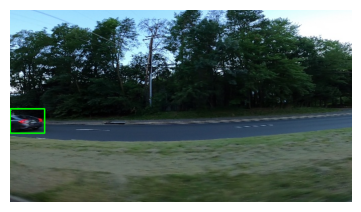

1/1 [==============================] - 0s 45ms/step


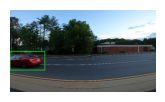

1/1 [==============================] - 0s 31ms/step


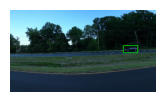

In [ ]:
# Initiating a test to evaluate the model's performance before training
test(model)


# Training the Convolutional Neural Network Model with Callbacks

Epoch 1/15
1/1 [==============================] - 0s 35ms/step


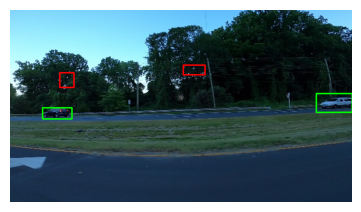

1/1 [==============================] - 0s 39ms/step


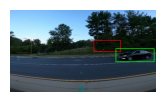

1/1 [==============================] - 0s 34ms/step


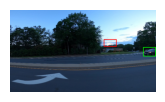

500/500 [==============================] - 156s 298ms/step - loss: 2702.1768 - accuracy: 0.8472
Epoch 2/15
1/1 [==============================] - 0s 37ms/step


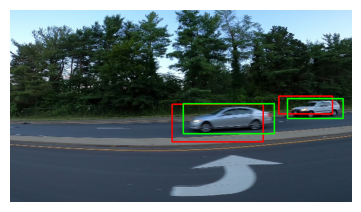

1/1 [==============================] - 0s 55ms/step


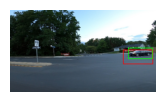

1/1 [==============================] - 0s 38ms/step


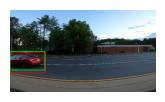

500/500 [==============================] - 148s 297ms/step - loss: 561.4058 - accuracy: 0.9710
Epoch 3/15
1/1 [==============================] - 0s 41ms/step


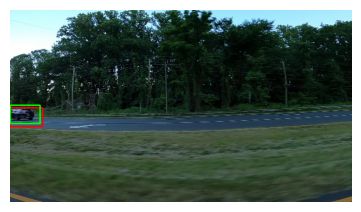

1/1 [==============================] - 0s 44ms/step


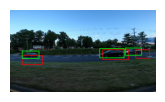

1/1 [==============================] - 0s 46ms/step


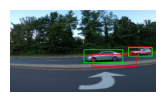

500/500 [==============================] - 152s 304ms/step - loss: 503.1108 - accuracy: 0.9753
Epoch 4/15
1/1 [==============================] - 0s 83ms/step


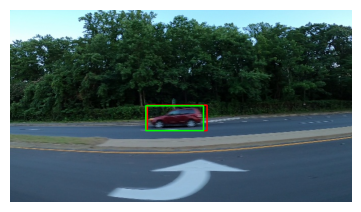

1/1 [==============================] - 0s 36ms/step


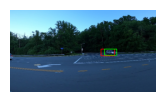

1/1 [==============================] - 0s 36ms/step


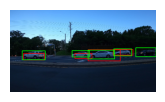

500/500 [==============================] - 152s 305ms/step - loss: 538.2219 - accuracy: 0.9743
Epoch 5/15
1/1 [==============================] - 0s 43ms/step


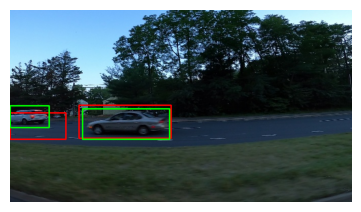

1/1 [==============================] - 0s 41ms/step


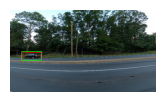

1/1 [==============================] - 0s 38ms/step


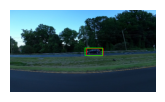

500/500 [==============================] - 152s 304ms/step - loss: 521.8932 - accuracy: 0.9778
Epoch 6/15
1/1 [==============================] - 0s 38ms/step


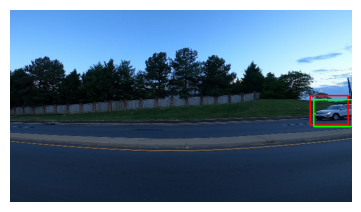

1/1 [==============================] - 0s 41ms/step


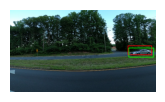

1/1 [==============================] - 0s 60ms/step


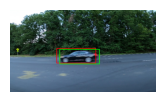

500/500 [==============================] - 152s 304ms/step - loss: 455.6764 - accuracy: 0.9790
Epoch 7/15
1/1 [==============================] - 0s 47ms/step


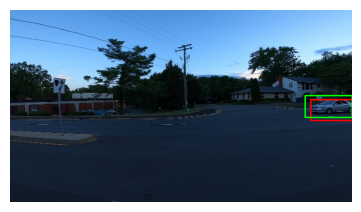

1/1 [==============================] - 0s 38ms/step


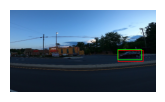

1/1 [==============================] - 0s 42ms/step


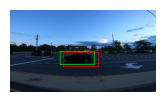

500/500 [==============================] - 157s 315ms/step - loss: 518.3815 - accuracy: 0.9787
Epoch 8/15
1/1 [==============================] - 0s 37ms/step


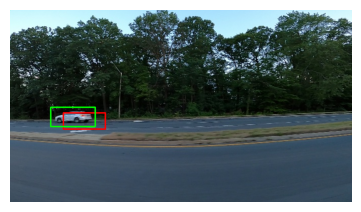

1/1 [==============================] - 0s 34ms/step


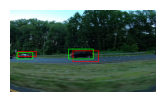

1/1 [==============================] - 0s 67ms/step


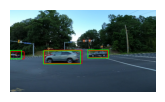

500/500 [==============================] - 153s 306ms/step - loss: 477.7766 - accuracy: 0.9805
Epoch 9/15
1/1 [==============================] - 0s 82ms/step


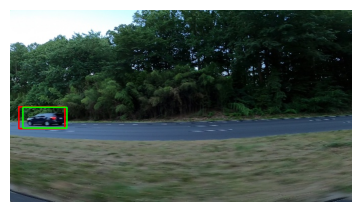

1/1 [==============================] - 0s 67ms/step


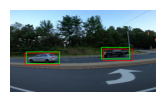

1/1 [==============================] - 0s 74ms/step


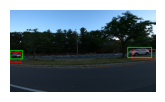

500/500 [==============================] - 153s 307ms/step - loss: 502.5168 - accuracy: 0.9783
Epoch 10/15
1/1 [==============================] - 0s 35ms/step


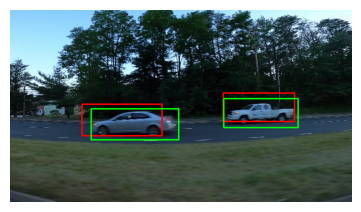

1/1 [==============================] - 0s 36ms/step


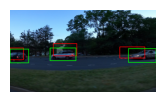

1/1 [==============================] - 0s 37ms/step


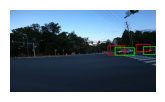

500/500 [==============================] - 154s 308ms/step - loss: 559.6538 - accuracy: 0.9825
Epoch 11/15
1/1 [==============================] - 0s 32ms/step


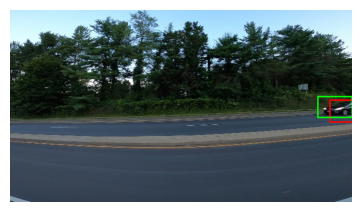

1/1 [==============================] - 0s 35ms/step


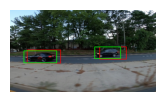

1/1 [==============================] - 0s 50ms/step


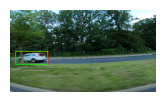

500/500 [==============================] - 154s 309ms/step - loss: 524.9465 - accuracy: 0.9840
Epoch 12/15
1/1 [==============================] - 0s 43ms/step


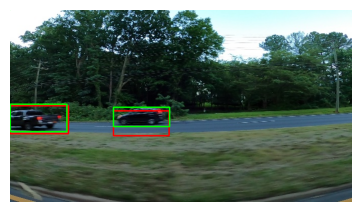

1/1 [==============================] - 0s 57ms/step


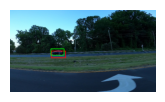

1/1 [==============================] - 0s 39ms/step


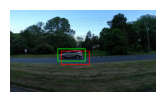

500/500 [==============================] - 154s 309ms/step - loss: 497.0846 - accuracy: 0.9815
Epoch 13/15
1/1 [==============================] - 0s 53ms/step


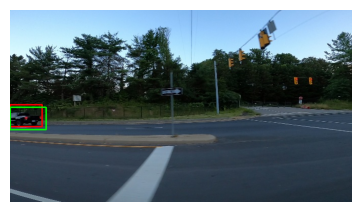

1/1 [==============================] - 0s 44ms/step


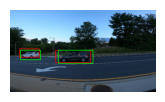

1/1 [==============================] - 0s 33ms/step


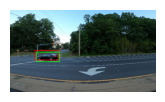

500/500 [==============================] - 155s 310ms/step - loss: 462.8389 - accuracy: 0.9895
Epoch 14/15
1/1 [==============================] - 0s 35ms/step


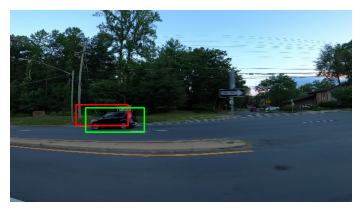

1/1 [==============================] - 0s 30ms/step


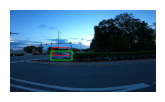

1/1 [==============================] - 0s 32ms/step


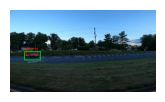

500/500 [==============================] - 152s 305ms/step - loss: 491.3316 - accuracy: 0.9859
Epoch 15/15
1/1 [==============================] - 0s 47ms/step


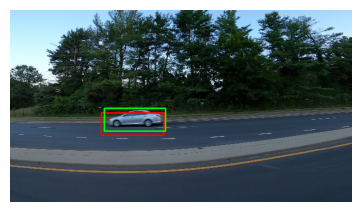

1/1 [==============================] - 0s 43ms/step


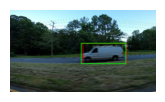

1/1 [==============================] - 0s 27ms/step


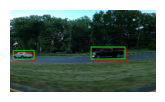

500/500 [==============================] - 155s 311ms/step - loss: 502.5565 - accuracy: 0.9880


In [ ]:
# Training the CNN model using the data generator and including a custom callback for testing
history = model.fit(data_generator(),           # Using the data generator function to provide training data
                    epochs=15,                   # Setting the number of epochs for training
                    steps_per_epoch=500,         # Defining the number of steps per epoch
                    callbacks=[TestImages()])    # Including the TestImages callback for visual evaluations


# Data Visualization



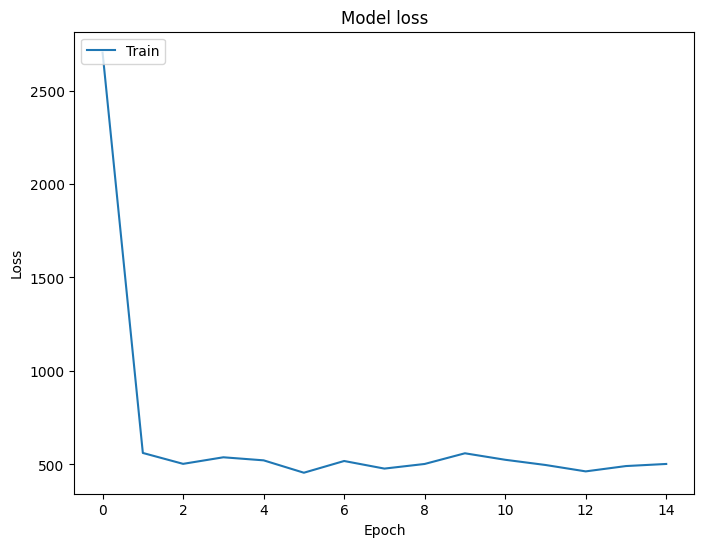

In [ ]:

# Since we are doing a regression task (predicting bounding box coordinates), we visualize the loss instead of accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()


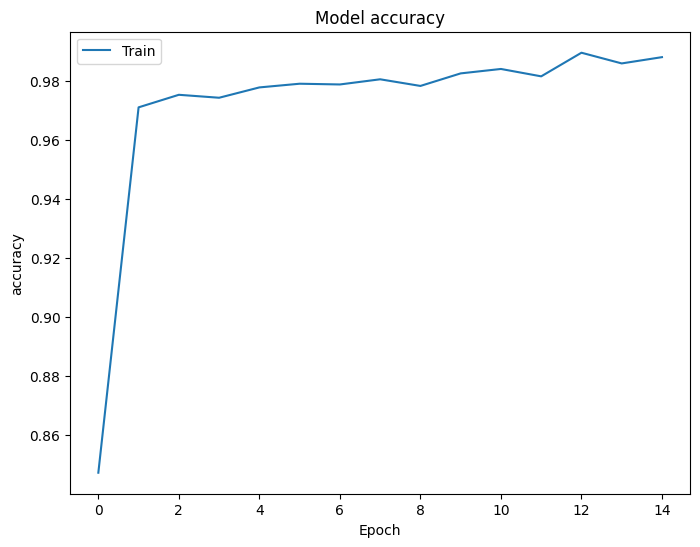

In [ ]:
# Since we are doing a regression task (predicting bounding box coordinates), we visualize the loss instead of accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
# Save the trained model

model.save('Car-object-detection.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
